<h1><center>In this Notebook, Image Classification is done with Cutting Edge Deep Learning Model (Inception.V3) using Tensorflow 2.0.</center></h1>

This notebook basically does image classification task using customized inception V3 model. \
Along with transfer learning, in this notebook, efficient data loading and data augmentation using ImageDataGenerator class of image module in tensorflow2.0 is also done.

### Importing the necessary libraries

In [1]:
import os
import numpy as np
import random
import tensorflow
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
import zipfile

### Set Directory where training and validation Images of Lung cancer are placed (For ImageDataGenerator Class)
This is done to reduce RAM usage using ImageDataGenerator class of image processing module inside tensorflow2.0.\
The benefit of referring to this directory where image data is placed is enormous reduction of memory resource as there is no need to load images into memory. Rather processing such as data augmentation will be done on the fly using ImageDataGenerator class.

In [2]:
base_dir = os.getcwd()+'\The IQ-OTHNCCD lung cancer dataset\\'

train_dir = os.path.join(base_dir, 'train')
train_Malignant_dir = os.path.join(train_dir, 'Malignant')
train_Benign_dir = os.path.join(train_dir, 'Benign')
train_Normal_dir=os.path.join(train_dir,'Normal')

validation_dir = os.path.join(base_dir, 'validation')
validation_Malignant_dir = os.path.join(validation_dir, 'Malignant')
validation_Benign_dir = os.path.join(validation_dir, 'Benign')
validation_Normal_dir=os.path.join(validation_dir,'Normal')

print('total training Malignant images :', len(os.listdir(train_Malignant_dir)))
print('total training Benign images :', len(os.listdir(train_Benign_dir)))
print('total training Normal images:',len(os.listdir(train_Normal_dir)))
print('total validation Malignant images :', len(os.listdir(validation_Malignant_dir)))
print('total validation Benign images :', len(os.listdir(validation_Benign_dir)))
print('totoal validation Normal images:',len(os.listdir(validation_Normal_dir)))

total training Malignant images : 281
total training Benign images : 60
total training Normal images: 208
total validation Malignant images : 280
total validation Benign images : 60
totoal validation Normal images: 208


### Understanding directory from inside

In [3]:
train_Malignant_fnames = os.listdir(train_Malignant_dir)
train_Benign_fnames = os.listdir(train_Benign_dir)
train_Normal_fnames=os.listdir(train_Normal_dir)

print("Printing five Malignant images name in train_Malignant_dir: ", train_Malignant_fnames[:5])
print("Printing five Benign images name in train_Benign_dir: ", train_Benign_fnames[:5])
print("Printing five Normal images name in train_Normal_dir: ",train_Normal_fnames[:5])

Printing five Malignant images name in train_Malignant_dir:  ['Malignant case (281).jpg', 'Malignant case (282).jpg', 'Malignant case (283).jpg', 'Malignant case (284).jpg', 'Malignant case (285).jpg']
Printing five Benign images name in train_Benign_dir:  ['Bengin case (1).jpg', 'Bengin case (10).jpg', 'Bengin case (11).jpg', 'Bengin case (116).jpg', 'Bengin case (117).jpg']
Printing five Normal images name in train_Normal_dir:  ['Normal case (209).jpg', 'Normal case (210).jpg', 'Normal case (211).jpg', 'Normal case (212).jpg', 'Normal case (213).jpg']


### Visualizing Images Randomly to check if everything is working the way we expect

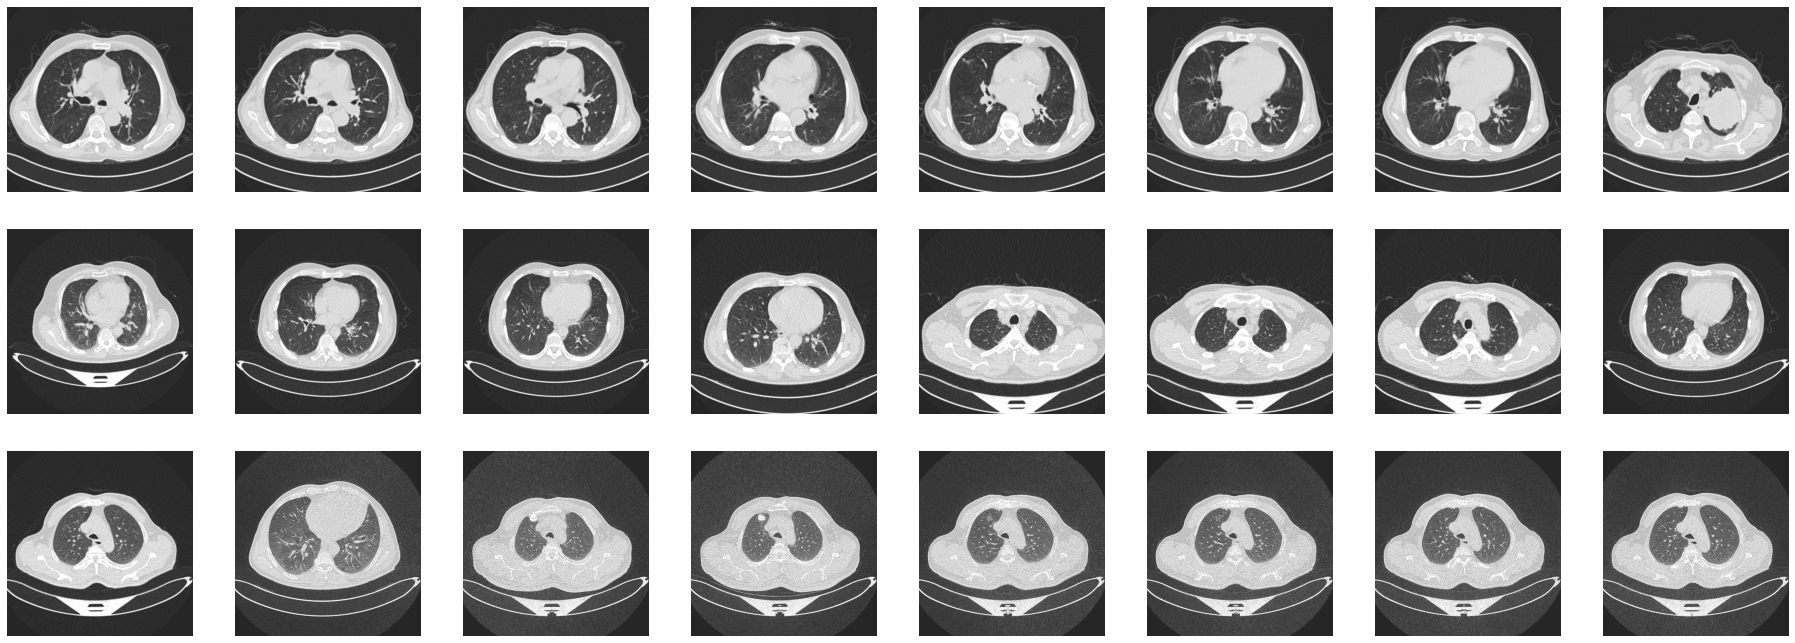

In [4]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 8
pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8
next_Malignant_pix = [os.path.join(train_Malignant_dir, fname) 
                for fname in train_Malignant_fnames[ pic_index-8:pic_index] 
               ]
next_Benign_pix = [os.path.join(train_Benign_dir, fname) 
                for fname in train_Benign_fnames[ pic_index-8:pic_index]
               ]
next_Normal_pix = [os.path.join(train_Normal_dir, fname) 
                for fname in train_Normal_fnames[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_Malignant_pix+next_Benign_pix+next_Normal_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

### Loading inceptionV3 model, loading its weight, and freezing its layers

In [5]:
local_weights_file = os.getcwd()+'/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

### Customizing InceptionV3 model for our own need

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer taken from InceptionV3 output shape: ', last_layer.output_shape)

last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)      
# Add a final sigmoid layer for classification
x = layers.Dense (3, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

last layer taken from InceptionV3 output shape:  (None, 7, 7, 768)


### Compiling the model

In [7]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

### Data Augmentation using ImageDataGenerator

In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

### Loading Images directly from directory without loading into RAM 

In [9]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

Found 549 images belonging to 3 classes.


In [10]:
# Flow validation images in batches of 32 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 548 images belonging to 3 classes.


### Fitting the model

In [79]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 15,
            epochs = 10,
            validation_steps = 10,
            verbose = 1)

Epoch 1/10
15/15 [==============================] - 10s 666ms/step - loss: 0.3300 - accuracy: 0.8720 - val_loss: 0.4500 - val_accuracy: 0.7844
Epoch 2/10
15/15 [==============================] - 10s 639ms/step - loss: 0.2459 - accuracy: 0.8896 - val_loss: 0.3484 - val_accuracy: 0.8500
Epoch 3/10
15/15 [==============================] - 10s 667ms/step - loss: 0.2857 - accuracy: 0.8687 - val_loss: 0.4218 - val_accuracy: 0.8219
Epoch 4/10
15/15 [==============================] - 10s 687ms/step - loss: 0.3085 - accuracy: 0.8786 - val_loss: 0.3964 - val_accuracy: 0.8562
Epoch 5/10
15/15 [==============================] - 10s 655ms/step - loss: 0.2753 - accuracy: 0.8985 - val_loss: 0.3133 - val_accuracy: 0.8844
Epoch 6/10
15/15 [==============================] - 10s 663ms/step - loss: 0.2849 - accuracy: 0.8808 - val_loss: 0.2916 - val_accuracy: 0.8938
Epoch 7/10
15/15 [==============================] - 10s 640ms/step - loss: 0.2514 - accuracy: 0.8918 - val_loss: 0.4642 - val_accuracy: 0.8594

### Evaluating model

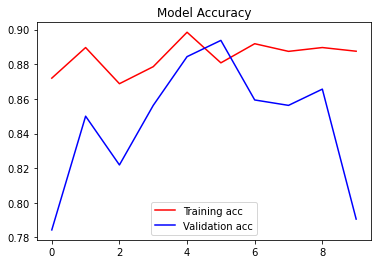

<Figure size 432x288 with 0 Axes>

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

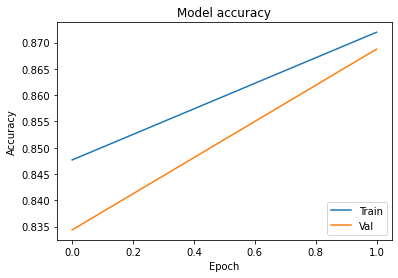

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

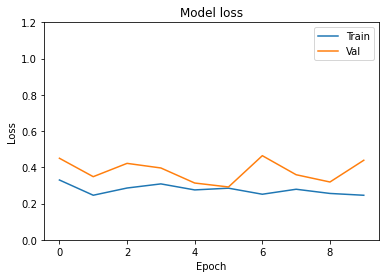

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

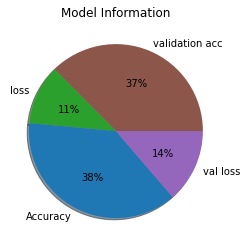

In [76]:
x=[max(history.history['val_accuracy']),min(history.history['loss']),max(history.history['accuracy']),min(history.history['val_loss'])]
labels = ['validation acc','loss','Accuracy','val loss']
colors = ['tab:brown', 'tab:green', 'tab:blue', 'tab:purple']
fig, ax = plt.subplots()

ax.pie(x, labels = labels,
       colors=colors,
          autopct='%.0f%%',
          shadow = True,
          startangle = 0)
ax.set_title('Model Information')
plt.show()

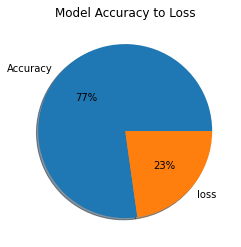

In [77]:
x=[max(history.history['accuracy']),min(history.history['loss'])]
labels = ['Accuracy', 'loss']

fig, ax = plt.subplots()
ax.pie(x, labels = labels,
          autopct='%.0f%%',
          shadow = True,
          startangle = 0)
ax.set_title('Model Accuracy to Loss')
plt.show()

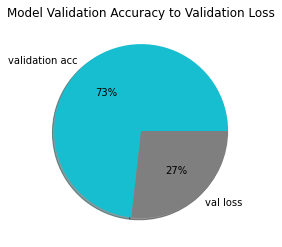

In [78]:
x=[max(history.history['val_accuracy']),min(history.history['val_loss'])]
labels = ['validation acc','val loss']
colors = [ 'tab:cyan', 'tab:gray']
fig, ax = plt.subplots()
ax.pie(x, labels = labels,
       colors=colors,
          autopct='%.0f%%',
          shadow = True,
          startangle = 0)
ax.set_title('Model Validation Accuracy to Validation Loss')
plt.show()

### Visualizing middle layers of neural networks

Let's define a new Model similar to inception v3 that will take an image as input, and will output intermediate representations for layers that we need. \
E.g. here we need representation for our inception v3 first to fifth layers.

In [53]:
successive_outputs = [layer.output for layer in model.layers[1:5]] 
visualization_model = Model(inputs = model.input, outputs = successive_outputs) #the input of inceptionV3 model

Let's prepare a random input image from the training Malignant set.

In [54]:
img_path = os.path.join(train_Malignant_dir, random.choice(train_Malignant_fnames))
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

x /= 255 # Rescale by 1/255

Let's run our image through our visualization model, thus obtaining all intermediate representations for this image.\
Also store the names of the layers, so can have them as part of our plot

In [55]:
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in visualization_model.layers]

1/1 [==============================] - 0s 45ms/step


Lets display our representation in simple manner

Total number of layers saved:  4


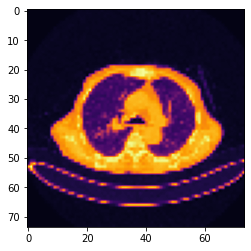

In [56]:
# Now let's display our representations for say convolutionn number 32
print("Total number of layers saved: ",len(successive_feature_maps))
layer_activation = successive_feature_maps[0] #taking layer 1 activations array
CONVOLUTION_NUM = 1 #visualizing 1st convolution
plt.imshow(layer_activation[0, : , :, CONVOLUTION_NUM], cmap='inferno')

Lets display our representation in automated way completely for all layers and all convolutions

C:\Users\yared\AppData\Local\Temp\ipykernel_8044\3201253398.py:15: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


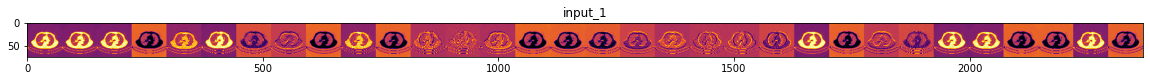

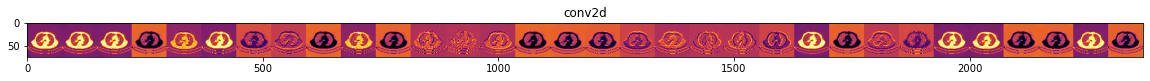

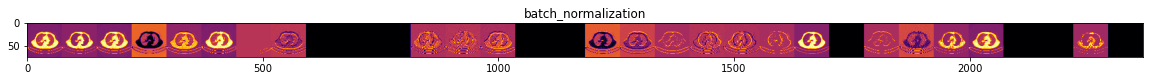

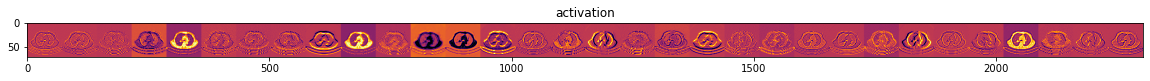

In [57]:
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
    if len(feature_map.shape) == 4: #(Check if layer is conv/maxpool?)
        n_features = feature_map.shape[-1] # feature map has shape (1, size, size, n_features)
        # Note that n_features is equivalent to number of convolutions
        size = feature_map.shape[1] 
        display_grid = np.zeros((size, size * n_features)) # We will tile our images in this matrix
        
        for i in range(n_features): # Note that n_features is equivalent to number of convolutions
            x = feature_map[0, :, :, i]
            
            # Postprocess the feature to make it visually palatable
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i*size : (i + 1)*size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='inferno')